In [1]:
import pickle
import hddCRP.behaviorDataHandlers
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:

context_length = 2;
num_runs = 2;
runs = range(num_runs);
num_warmup_samples = 5000
num_samples        = 20000
overwrite_existing_results = False

simple_model = False
single_concentration = False
sequential_distances_only = True # if false, model setup more as a "smoother". If true, can simulate from the model

if(sequential_distances_only):
    results_directory = "Results/sequentialModel/"
else:
    results_directory = "Results/"
if(simple_model):
    results_directory += "simple/"
elif(single_concentration):
    results_directory += "singleAlpha/"

if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)

data_filename = 'data/Data_turns_all_by_session.pkl';
with open(data_filename, 'rb') as data_file:
    data = pickle.load(data_file)

subjects = list(data["data"].keys())
# subjects = ["A1"] 
subjects.sort()
print("subjects = " + str(subjects))



subjects = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D1', 'D2', 'E1', 'E2', 'F1', 'F2', 'G1', 'G2', 'H1', 'I1', 'I2', 'J1', 'J2']


In [3]:

for run_idx in runs:
    print(f"RUN {run_idx}")
    for subject_idx, subject in enumerate(subjects):
        print(f"subject_idx {subject_idx}: {subject}")
        filename = "{results_directory}/Subject_{subject_id}_context_{context_length}_run_{run_idx}.pkl".format(results_directory=results_directory, subject_id=subject, run_idx=run_idx, context_length=context_length)
        if(not os.path.isfile(filename) or overwrite_existing_results):
            # for each run, should do some randomization of initial parameters (with known seeds so we can repeat everything)

            seed = subject_idx * 1000 + run_idx;
            rng = np.random.Generator(np.random.MT19937(seed))

            sequences = data["data"][subject]["data"]; # turns in each session
            session_types = data["data"][subject]["task"] # which maze

            ii = session_types.index("C")
            sequences = [sequences[ii]]
            session_types = [session_types[ii]]


            model = hddCRP.behaviorDataHandlers.create_hddCRP(sequences, session_types, rng = rng, 
                        sequential_distances_only=sequential_distances_only, depth=(context_length+1), include_timescales=(not simple_model))

            tau_names = [str(xx) for xx in model.weight_param_labels]
            alphas_names = ["alpha_concentration_no_context", "alpha_concentration_one_back_context", "alpha_concentration_two_back_context"]
            alphas_names = alphas_names[:(context_length+1)]
            model, samples, step_size_settings = hddCRP.behaviorDataHandlers.sample_model_for_maze_data(model, num_samples=num_samples, num_warmup_samples=num_warmup_samples, 
                print_every=5000, single_concentration_parameter=(single_concentration or simple_model))
            
            MCMC_info = {"step_size_settings" : step_size_settings.to_dict(),
                        "num_warmup_samples" : num_warmup_samples,
                        "num_samples" : num_samples,
                        "seed" : seed, 
                        "sequential_distances_only" : sequential_distances_only}
            samples["tau_parameter_names"] = tau_names
            samples["alphas_names"] = alphas_names
            samples["stats"] = {"contexts" : model._groupings, "observations" : model._Y}
            
            # save results to filename
            with open(filename, "wb") as results_file:
                results_data = {"MCMC_info" : MCMC_info,
                                "samples" : samples}
                pickle.dump(results_data, results_file)

RUN 0
subject_idx 0: A1
subject_idx 1: A2
subject_idx 2: B1
subject_idx 3: B2
subject_idx 4: C1
subject_idx 5: C2
subject_idx 6: D1
subject_idx 7: D2
subject_idx 8: E1
subject_idx 9: E2
subject_idx 10: F1
subject_idx 11: F2
subject_idx 12: G1
subject_idx 13: G2
subject_idx 14: H1
subject_idx 15: I1
Sample 0 / 25000
Sample 5000 / 25000
Sample 10000 / 25000
Sample 15000 / 25000
Sample 20000 / 25000
subject_idx 16: I2
Sample 0 / 25000
Sample 5000 / 25000
Sample 10000 / 25000
Sample 15000 / 25000
Sample 20000 / 25000
subject_idx 17: J1
Sample 0 / 25000
Sample 5000 / 25000
Sample 10000 / 25000
Sample 15000 / 25000
Sample 20000 / 25000
subject_idx 18: J2
Sample 0 / 25000
Sample 5000 / 25000
Sample 10000 / 25000
Sample 15000 / 25000
Sample 20000 / 25000
RUN 1
subject_idx 0: A1
Sample 0 / 25000
Sample 5000 / 25000
Sample 10000 / 25000
Sample 15000 / 25000
Sample 20000 / 25000
subject_idx 1: A2
Sample 0 / 25000
Sample 5000 / 25000
Sample 10000 / 25000
Sample 15000 / 25000
Sample 20000 / 25000
s

In [116]:
# example for loading results and computing estimates with error bars for a single subject
#subject = 'A1'

subjects_2 = np.array([True if xx.endswith('2') else False for xx in subjects])
subjects_1 = np.array([True if xx.endswith('1') else False for xx in subjects])

taus = np.zeros((num_samples,1,len(runs),len(subjects)))
alphas = np.zeros((num_samples,context_length+1,len(runs),len(subjects)))

for run_idx in runs:
    for subject_idx, subject in enumerate(subjects):
        filename = "{results_directory}/Subject_{subject_id}_context_{context_length}_run_{run_idx}.pkl".format(results_directory=results_directory, subject_id=subject, run_idx=run_idx, context_length=context_length)
        with open(filename, "rb") as file:
            results = pickle.load(file)

            ss = range(results["MCMC_info"]["num_warmup_samples"], results["MCMC_info"]["num_warmup_samples"]+results["MCMC_info"]["num_samples"])
            taus[:,:,run_idx,subject_idx] = np.exp(results["samples"]["log_taus"][ss,:])
            alphas[:,:,run_idx,subject_idx] = results["samples"]["alphas"][ss,:]

        # ci_range = [2.5, 97.5]

        # mean_taus = np.mean(taus, axis=0)
        # mean_alphas = np.mean(alphas, axis=0)
        # std_taus = np.std(taus, axis=0)
        # std_alphas = np.std(alphas, axis=0)
        # ci95_taus = np.percentile(taus, ci_range, axis=0)
        # ci95_alphas = np.percentile(alphas, ci_range, axis=0)

        # accepted = results["samples"]["accepted"][ss]
        # print("Fraction of accepted MH samples: " + str(np.mean(accepted)))

    # plt.subplot(1,2,1)
    # plt.plot(taus)

    # plt.subplot(1,2,2)
    # plt.plot(alphas)
    # plt.show()


array([13], dtype=int64)

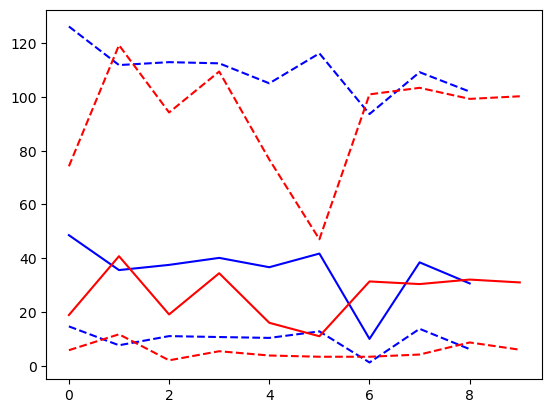

In [50]:
# plt.plot(np.mean(taus[:,0,0,subjects_2],axis=0));
# plt.plot(np.mean(taus[:,0,1,subjects_2],axis=0));
plt.plot(np.percentile(taus[:,0,0,subjects_2],[50], axis=0).T, 'b-');
plt.plot(np.percentile(taus[:,0,0,subjects_2],[5,95], axis=0).T, 'b--');
plt.plot(np.percentile(taus[:,0,0,subjects_1],[50], axis=0).T, 'r-');
plt.plot(np.percentile(taus[:,0,0,subjects_1],[5,95], axis=0).T, 'r--');
# plt.plot(np.percentile(taus[:,0,1,subjects_2],[5, 50, 95], axis=0));
# plt.plot(np.median(taus[:,0,0,subjects_1],axis=0));
# plt.plot(np.median(taus[:,0,1,subjects_1],axis=0));
# plt.plot(np.median(alphas[:,0,0,subjects_2],axis=0));
# plt.plot(np.median(alphas[:,0,1,subjects_2],axis=0));
# plt.plot(np.median(alphas[:,1,0,subjects_1],axis=0));
# plt.plot(np.median(alphas[:,1,1,subjects_1],axis=0));
# plt.plot(np.median(alphas[:,1,0,subjects_2],axis=0));
# plt.plot(np.median(alphas[:,1,1,subjects_2],axis=0));

subjects=np.array(subjects)
subjects[subjects_2][6]
np.where(subjects=='G2')[0]

In [183]:
from scipy.stats import ranksums
from scipy.stats.mstats import gmean

mc_seed = 1003;
rng = np.random.Generator(np.random.MT19937(mc_seed))
def p_difference(a, b, M = 100000, rng = np.random.default_rng(), prctiles = [2.5,50,97.5]):
    aas = np.zeros((M, a.shape[1]))
    bbs = np.zeros((M, b.shape[1]))
    for kk in range(a.shape[1]):
        aas[:,kk] = a[rng.integers(0,a.shape[0],size=(M)),kk]
    for kk in range(b.shape[1]):
        bbs[:,kk] = b[rng.integers(0,b.shape[0],size=(M)),kk]
    aas = np.median(aas,axis=1)
    bbs = np.median(bbs,axis=1)
    # aas = gmean(aas,axis=1)
    # bbs = gmean(bbs,axis=1)
    dds = bbs-aas
    return np.mean(aas < bbs), np.mean(dds), np.percentile(dds, prctiles)

run_idx = 0;
alpha_idx = 1;
param = taus[:,0,run_idx,:].squeeze()
# param = alphas[:,alpha_idx,run_idx,:].squeeze()

pps = np.zeros((len(subjects)))
mean_diffs = np.zeros((len(subjects)))
prctile_diffs = np.zeros((len(subjects), 3))

# testing for what happens to stats when leaving out single rat
# for ss in range(len(subjects)):
#     subjects_1c = np.array(subjects_1);
#     subjects_2c = np.array(subjects_2);
#     subjects_1c[ss] = False;
#     subjects_2c[ss] = False;
#     a = param[:,subjects_1c];
#     b = param[:,subjects_2c];

#     pps[ss], mean_diffs[ss], prctile_diffs[ss,:] = p_difference(a, b, rng=rng)

# a = np.median(param[:,subjects_1],axis=0,keepdims=True);
# b = np.median(param[:,subjects_2],axis=0,keepdims=True);
# b = np.median(param[:,subjects_1],axis=0,keepdims=True);
a = param[:,subjects_1];
b = param[:,subjects_2];
p_all, mean_diff_all, prctile_diffs_all = p_difference(a,b,rng=rng)

stats_ranksum, p_ranksum = ranksums(np.median(a,axis=0), np.median(b,axis=0))

print(p_ranksum)
# print(pps)
print(p_all)
# print(mean_diff_all)
print(prctile_diffs_all)


0.041226833337163676
0.78575
[-12.8911878    8.48921599  32.85064511]


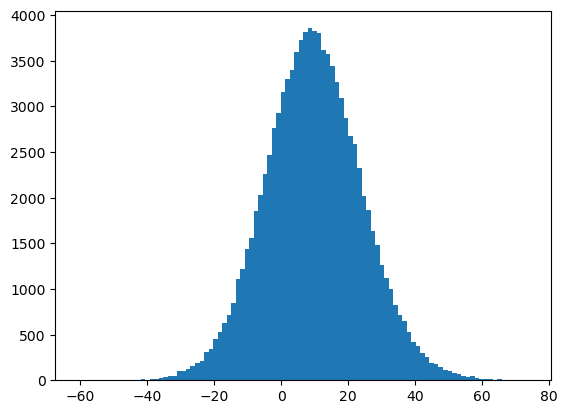

In [147]:

def diffs(a, b, M = 100000, rng = np.random.default_rng()):
    aas = np.zeros((M, a.shape[1]))
    bbs = np.zeros((M, b.shape[1]))
    for kk in range(a.shape[1]):
        aas[:,kk] = a[rng.integers(0,a.shape[0],size=(M)),kk]
    for kk in range(b.shape[1]):
        bbs[:,kk] = b[rng.integers(0,b.shape[0],size=(M)),kk]
    aas = np.mean(aas,axis=1)
    bbs = np.mean(bbs,axis=1)
    dds = bbs-aas
    return dds
    
a = param[:,subjects_1];
b = param[:,subjects_2];
d = diffs(a,b,rng=rng)

plt.hist(d,100);